In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import datetime

In [9]:
data_set = pd.read_csv("BTC.csv")

In [10]:
data_set
# open : 시가
# high : 고가
# low : 저가
# close : 종가
# volume : 거래량

,Date,Open,High,Low,Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...,...
2255,2020-11-19,17803.861330,18119.546880,17382.554690,17817.089840,36985055355
2256,2020-11-20,17817.083980,18773.226560,17765.794920,18621.314450,36992873940
2257,2020-11-21,18621.316410,18936.621090,18444.359380,18642.232420,39650210707
2258,2020-11-22,18642.232420,18688.968750,17671.384770,18370.001950,41280434226


In [11]:
data_set["Date"] = pd.to_datetime(data_set["Date"], format="%Y/%m/%d %H:%M:%S")
data_set["Year"] = data_set["Date"].dt.year
data_set["Month"] = data_set["Date"].dt.month
data_set["Day"] = data_set["Date"].dt.day

In [12]:
data_set = data_set.dropna()

Text(0, 0.5, 'price')

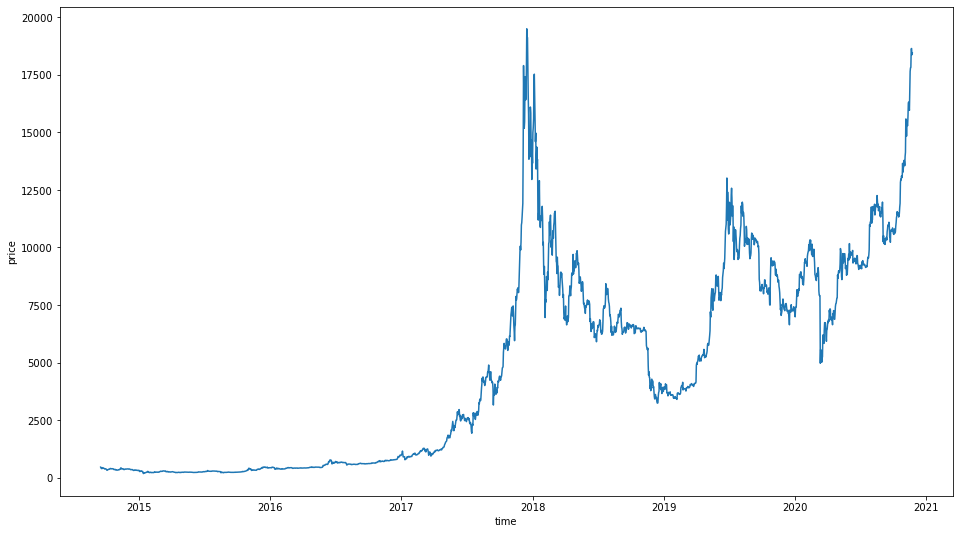

In [13]:
import seaborn as sns

plt.figure(figsize=(16, 9))
sns.lineplot(y=data_set["Close"], x=data_set["Date"])
plt.xlabel('time')
plt.ylabel('price')

In [14]:
high_price = data_set["High"].values
low_price = data_set["Low"].values
mid_price = (high_price + low_price)/2

In [15]:
# window 만들기
# 50일까지의 데이터로 학습, 51일 데이터를 예측

seq_len = 50
squence_len = seq_len + 1

res = []
for i in range(len(mid_price) - squence_len):
    res.append(mid_price[i:i+squence_len])

In [16]:
# 정규화
# 읽기 어려운 데이터들을 한눈에 볼 수 있게 미니어쳐화 시킴
normalized_data = []
for window in res:
    normalized_window = [((float(p)/float(window[0]))-1) for p in window]
    normalized_data.append(normalized_window)
res = np.array(normalized_data)

In [17]:
res

array([[ 0.        , -0.05499917, -0.11756406, ..., -0.28650137,
        -0.26780912, -0.24897565],
       [ 0.        , -0.06620617, -0.06527282, ..., -0.22519551,
        -0.20526594, -0.2016819 ],
       [ 0.        ,  0.00099953, -0.00832137, ..., -0.14891913,
        -0.14508099, -0.1516322 ],
       ...,
       [ 0.        , -0.01430547, -0.01248639, ...,  0.66968067,
         0.65824859,  0.70668153],
       [ 0.        ,  0.00184548,  0.00611326, ...,  0.6823149 ,
         0.73145074,  0.7713481 ],
       [ 0.        ,  0.00425992,  0.0145858 , ...,  0.72826128,
         0.76808515,  0.71981045]])

In [18]:
# Divide Train_set and Test_set

row = int(round(res.shape[0]*0.9))
train = res[:row, :]
np.random.shuffle(train)

# x_train에 50개 넣고 y_train에 마지막 1개
x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
y_train = train[:, -1]

# x_test에 50개 넣고 y_test에 마지막 1개
x_test = res[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = res[row:, -1]

x_train.shape, x_test.shape

((1988, 50, 1), (221, 50, 1))

In [19]:
# 학습을 시켜봅시다
# LSTM LSTM DENSE

model = Sequential()

# LSTM 50개 가져오기
model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))
# LSTM 한번 더
model.add(LSTM(64, return_sequences=False))
# 다음날 하루의 가격 예측
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="rmsprop")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(x_train, y_train, validation_data=(x_test, y_test),
          batch_size=5, epochs=20)

Epoch 1/20
398/398 [==============================] - 13s 33ms/step - loss: 0.0117 - val_loss: 0.0023
Epoch 2/20
398/398 [==============================] - 13s 31ms/step - loss: 0.0053 - val_loss: 0.0013
Epoch 3/20
398/398 [==============================] - 13s 33ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 4/20
398/398 [==============================] - 13s 32ms/step - loss: 0.0026 - val_loss: 7.6784e-04
Epoch 5/20
398/398 [==============================] - 12s 31ms/step - loss: 0.0024 - val_loss: 0.0062
Epoch 6/20
398/398 [==============================] - 13s 32ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 7/20
398/398 [==============================] - 13s 32ms/step - loss: 0.0023 - val_loss: 6.0209e-04
Epoch 8/20
398/398 [==============================] - 13s 32ms/step - loss: 0.0022 - val_loss: 6.9556e-04
Epoch 9/20
398/398 [==============================] - 13s 32ms/step - loss: 0.0021 - val_loss: 7.0295e-04
Epoch 10/20
398/398 [==============================] - 13s 32ms/st

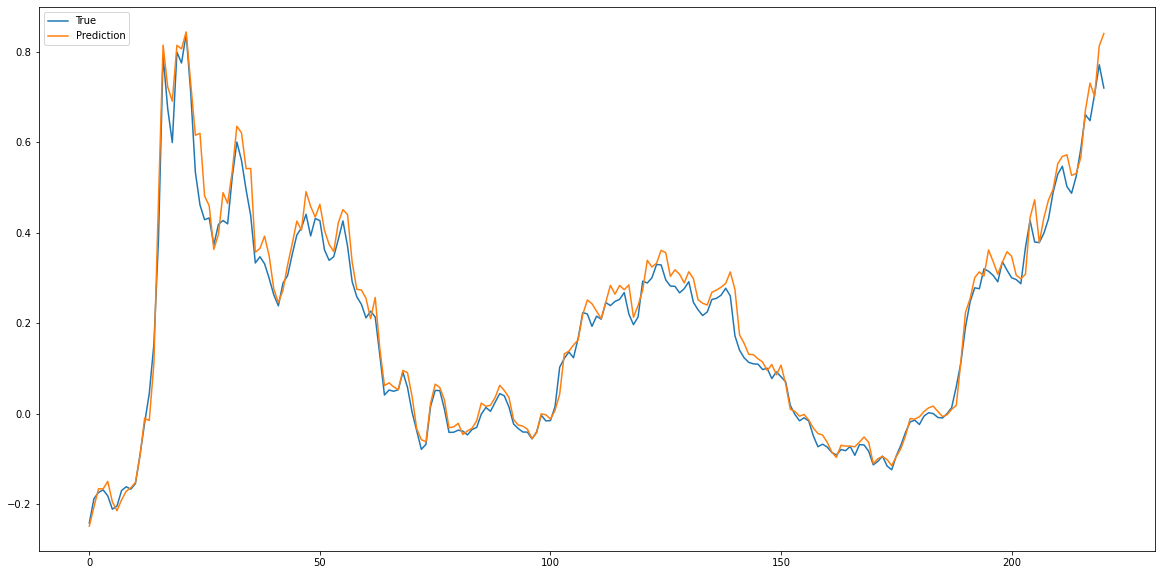

In [21]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()